# Attempt to extract refractive index from time domain

In [1]:
import torch
import numpy as np
from Matrix_methods.Simulate import simulate_reference, simulate_parallel, c 
import matplotlib.pyplot as plt

from TimeDomain_extractor import TimeDomainExtractor

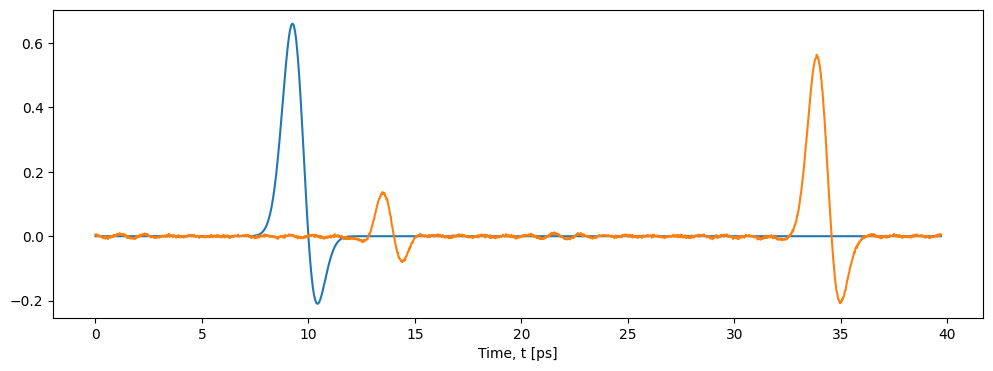

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**11  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Experimental material parameters (ground truth)
material_params_exp = [(3.46+0.01j, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Initial guesses
n_init, k_init, D_init = 3.45, 0.015, 3e-3

# Create and run the optimizer
extractor = TimeDomainExtractor(reference_pulse, experimental_pulse, deltat, n_init, k_init, D_init, lr=0.01)
optimized_n, optimized_k, optimized_D = extractor.optimize(num_iterations=100, updates=10, alpha=1)

initial_params = [(n_init + 1j*k_init, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Optimizing for 100 with loss multiplier 1.
Iteration 0, Loss: 0.0019288603216409683, n: 3.4600000381469727, k: 0.004999999888241291, D: 0.0029999997932463884
Iteration 10, Loss: 0.0020066602155566216, n: 3.4860825538635254, k: -0.012112371623516083, D: 0.0029999997932463884
Iteration 20, Loss: 0.0012708245776593685, n: 3.476539134979248, k: -0.0009651731234043837, D: 0.0029999997932463884
Iteration 30, Loss: 0.00014369892596732825, n: 3.4555397033691406, k: 0.010945827700197697, D: 0.0029999997932463884
Iteration 40, Loss: 0.00017976704111788422, n: 3.458146333694458, k: 0.006590936332941055, D: 0.0029999997932463884
Iteration 50, Loss: 0.00019273924408480525, n: 3.4614570140838623, k: 0.004358265083283186, D: 0.0029999997932463884
Iteration 60, Loss: 0.0001753946562530473, n: 3.458345651626587, k: 0.002822042675688863, D: 0.0029999997932463884
Iteration 70, Loss: 1.0637597370077856e-05, n: 3.4603896141052246, k: 0.011718441732227802, D: 0.0029999997932463884
Iteration 80, Loss: 0.0001

[((3.460928440093994+0.01167647261172533j), 0.0029999997932463884)]


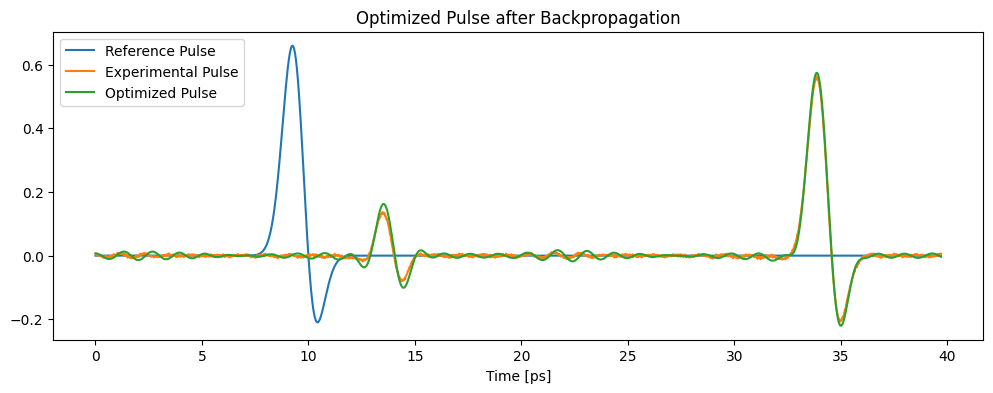

In [4]:
best_params = [(optimized_n + 1j*optimized_k, optimized_D)]
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
#plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

In [5]:
print(f'forward pass single run time: {extractor.forward_time}s')
print(f'backwards pass single run time: {extractor.backwards_time}s')
print(f'optimizer single run time: {extractor.optimizer_time}s')

forward pass single run time: 0.3083329159999266s
backwards pass single run time: 0.5979874580225442s
optimizer single run time: 0.00016029199468903244s


In [6]:
print(f'forward pass 100 iter run time: {extractor.forward_time * 100} s')
print(f'backwards pass 100 iter run time: {extractor.backwards_time * 100} s')
print(f'optimizer 100 iter run time: {extractor.optimizer_time * 100} s')

forward pass 100 iter run time: 30.833291599992663 s
backwards pass 100 iter run time: 59.798745802254416 s
optimizer 100 iter run time: 0.016029199468903244 s


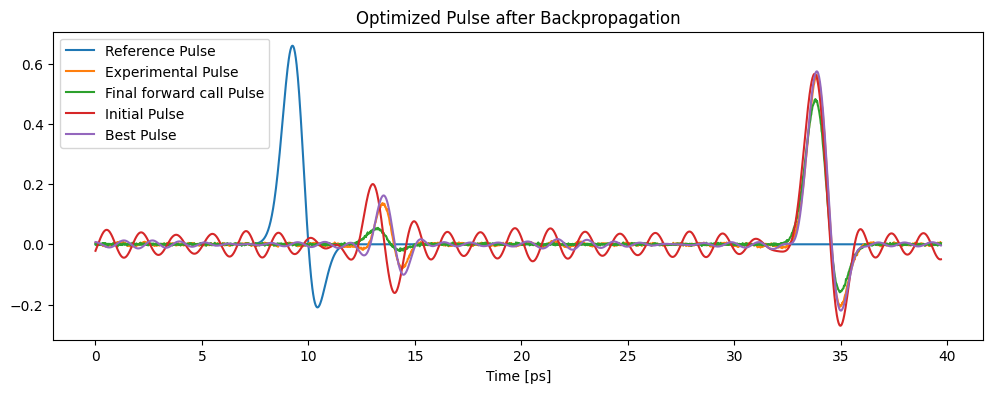

In [7]:
# Optimized vs final forward() call

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, extractor.forward().detach().numpy(), label='Final forward call Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Best Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()